target_native_gates = ['Hadamard','RX','RY','RZ','CNOT']

In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_level_3 import optimization_level_3
from qco_spec_table import make_spec_table_loop, show_circuit
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
[ds] = qml.data.load("ketgpt")

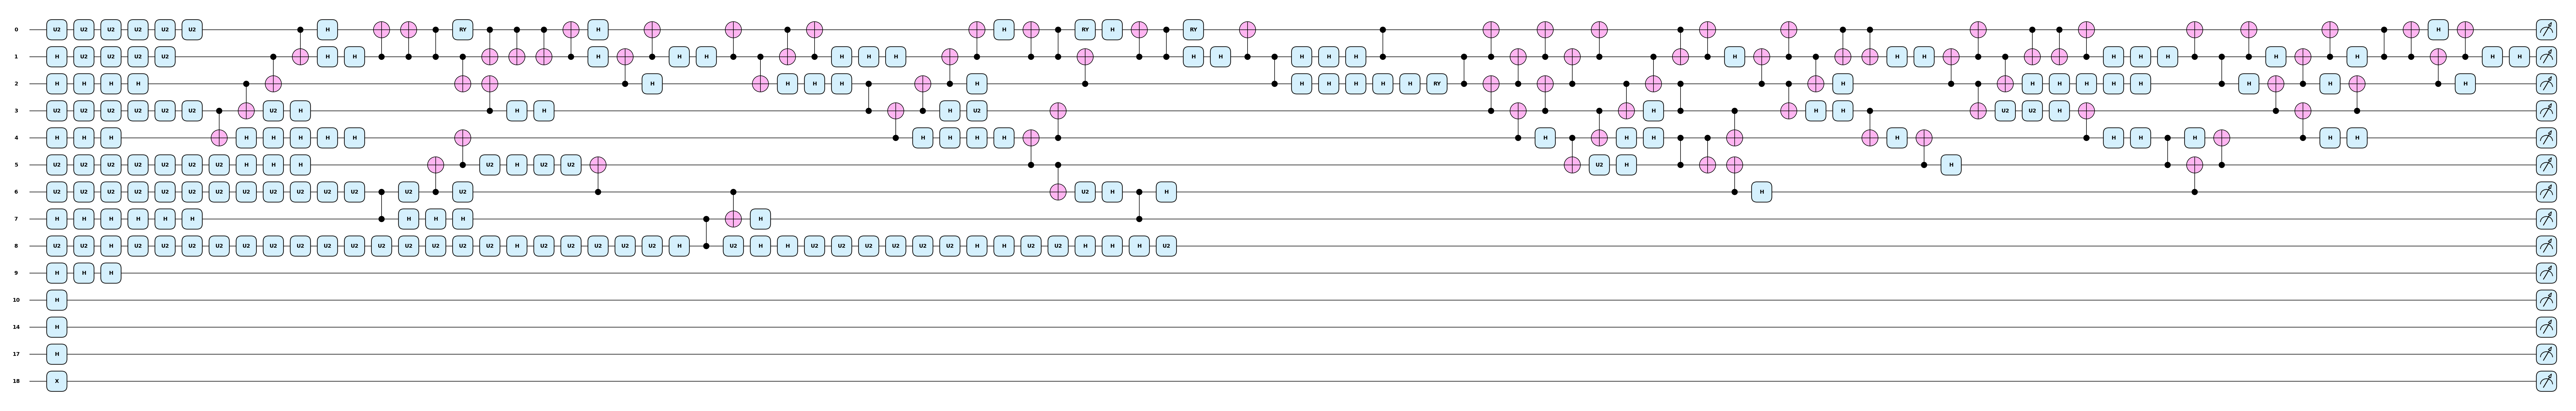

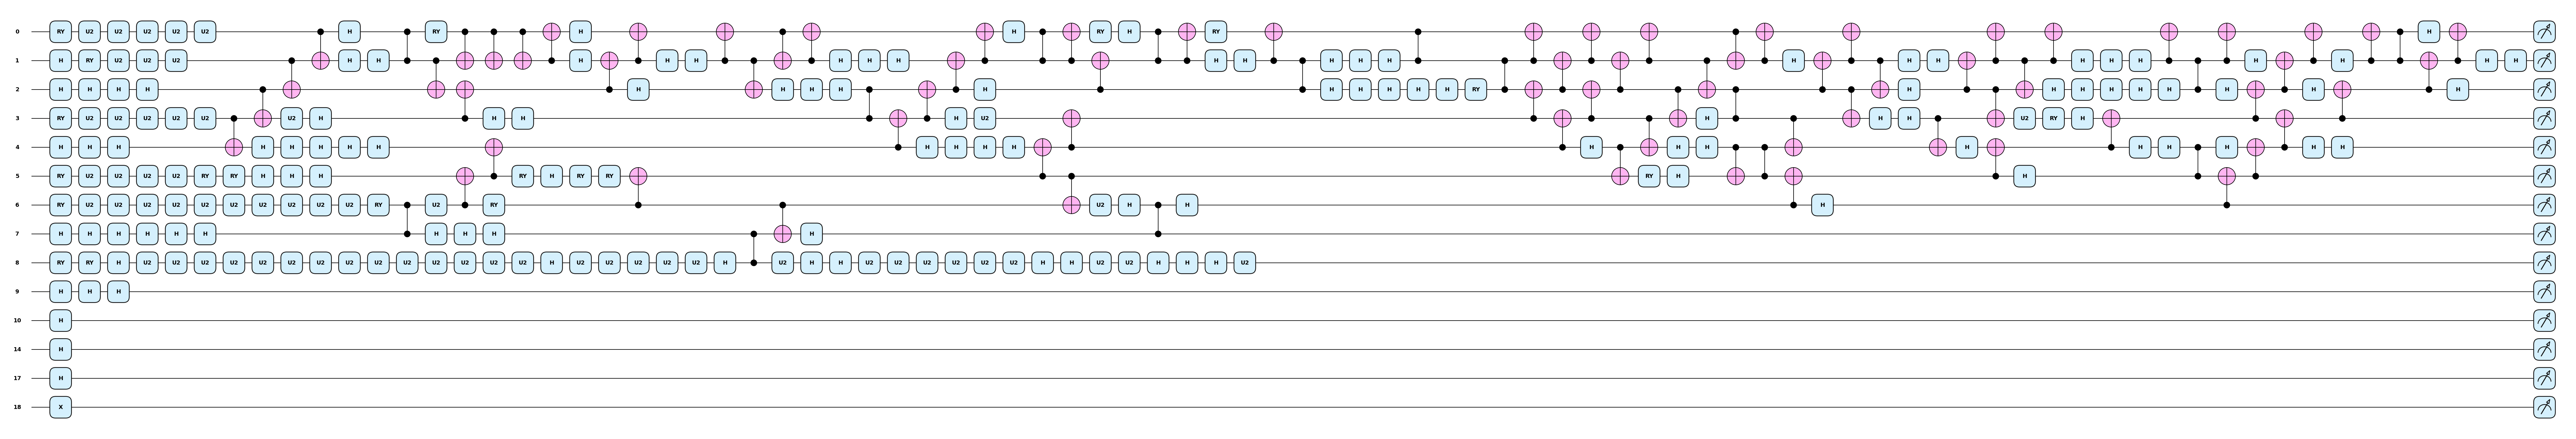

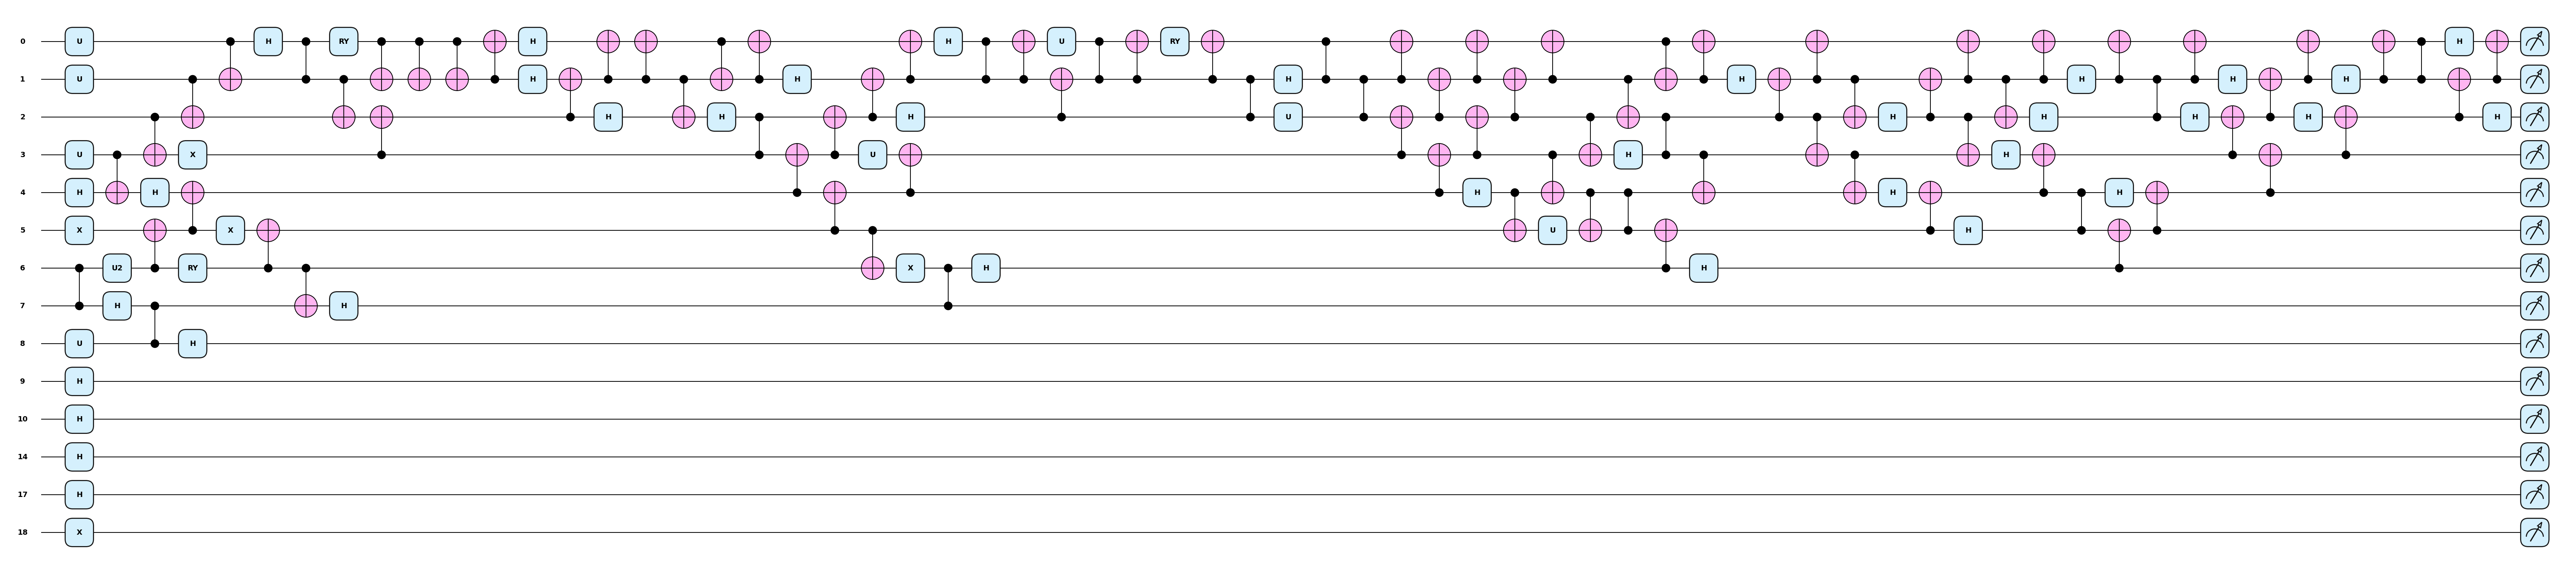

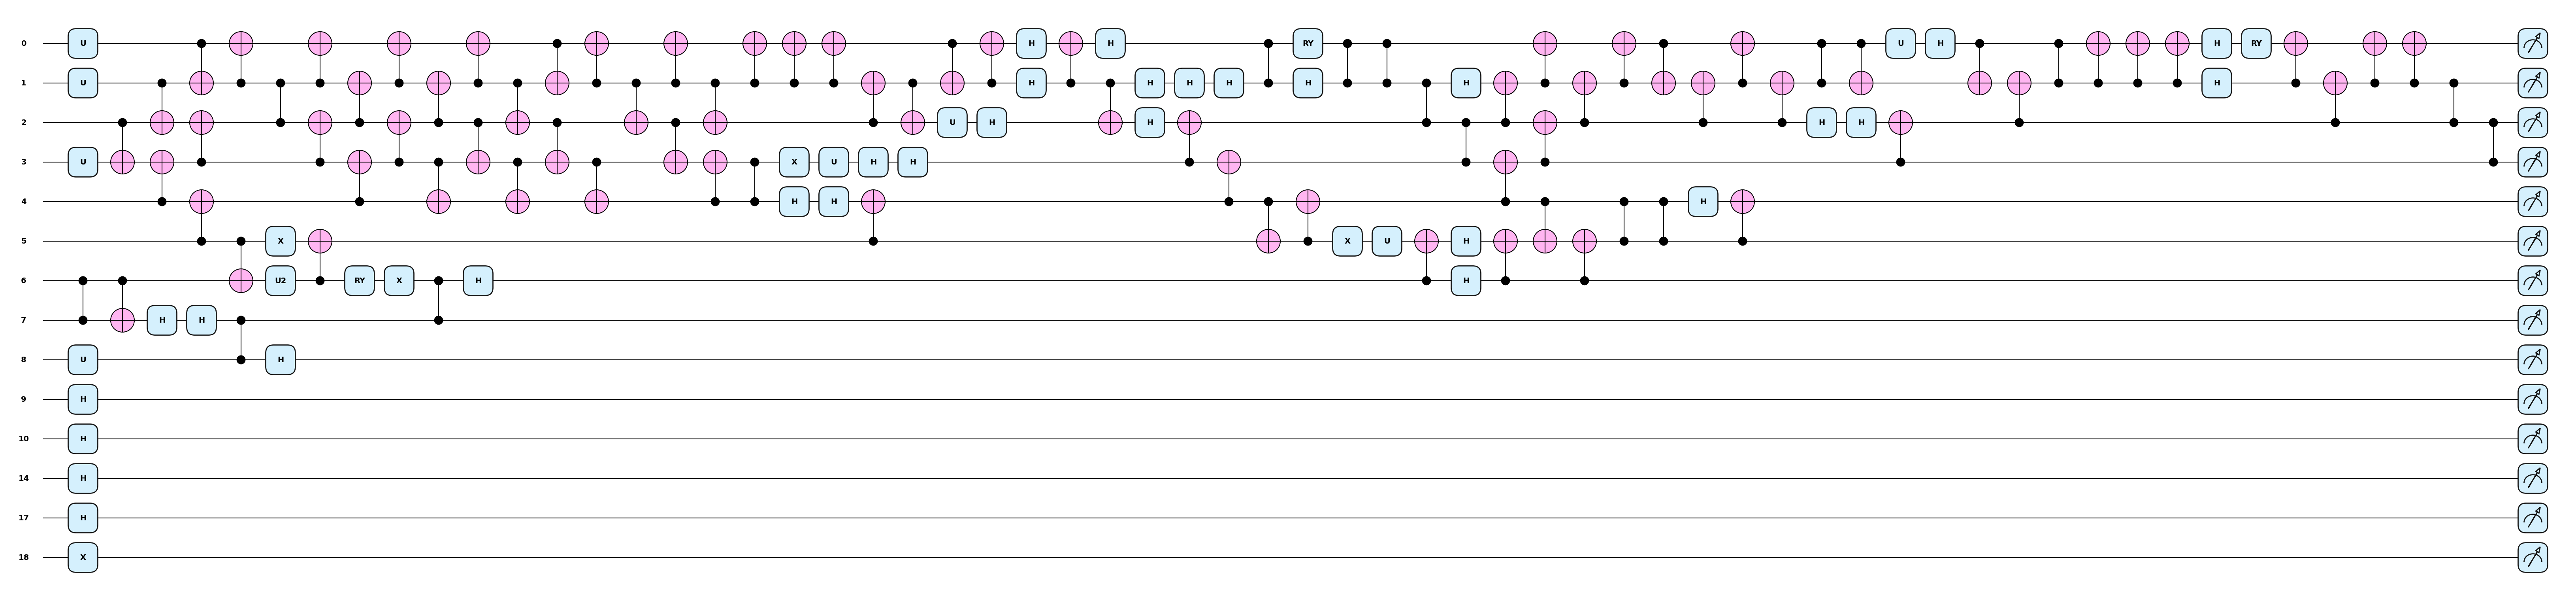

In [3]:
# example
seed = 3
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

show_circuit(circuit)
show_circuit(optimization_level_2(circuit)) # 2-qubit gates
show_circuit(optimization_level_1(optimization_level_2(circuit))) # 1-qubit gates
show_circuit(optimization_level_3(optimization_level_1(optimization_level_2(circuit)))) # 1- and 2-qubit gates

In [4]:
make_spec_table_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)

,Original,Qiskit,PennyLane,Levels 2+1
gates,291,147,348,94
1q gates,198,68,254,29
2q gates,93,79,94,65
depth,92,61,107,45
gate types,6,7,5,7


In [5]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        df = make_spec_table_loop(circuit, optimization_level_1, optimization_level_2, optimization_level_3)
        dfs.append(df)
    except:
        pass

In [6]:
len(dfs)                                    

1000

In [7]:
dfs[0]

,Original,Qiskit,PennyLane,Levels 2+1
gates,141,37,74,31
1q gates,116,18,45,12
2q gates,25,19,29,19
depth,32,16,40,12
gate types,5,4,4,4


In [8]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,PennyLane,Levels 2+1
gates,0.262,0.525,0.220
1q gates,0.155,0.388,0.103
2q gates,0.760,1.160,0.760
depth,0.500,1.250,0.375
gate types,0.800,0.800,0.800


In [34]:
for df in dfs_ratio:
    df.rename(columns={'Levels 2+1':'Levels 3+2+1'}, inplace=True)
dfs_ratio[0]

,Qiskit,PennyLane,Levels 3+2+1
gates,0.262,0.525,0.220
1q gates,0.155,0.388,0.103
2q gates,0.760,1.160,0.760
depth,0.500,1.250,0.375
gate types,0.800,0.800,0.800


In [35]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

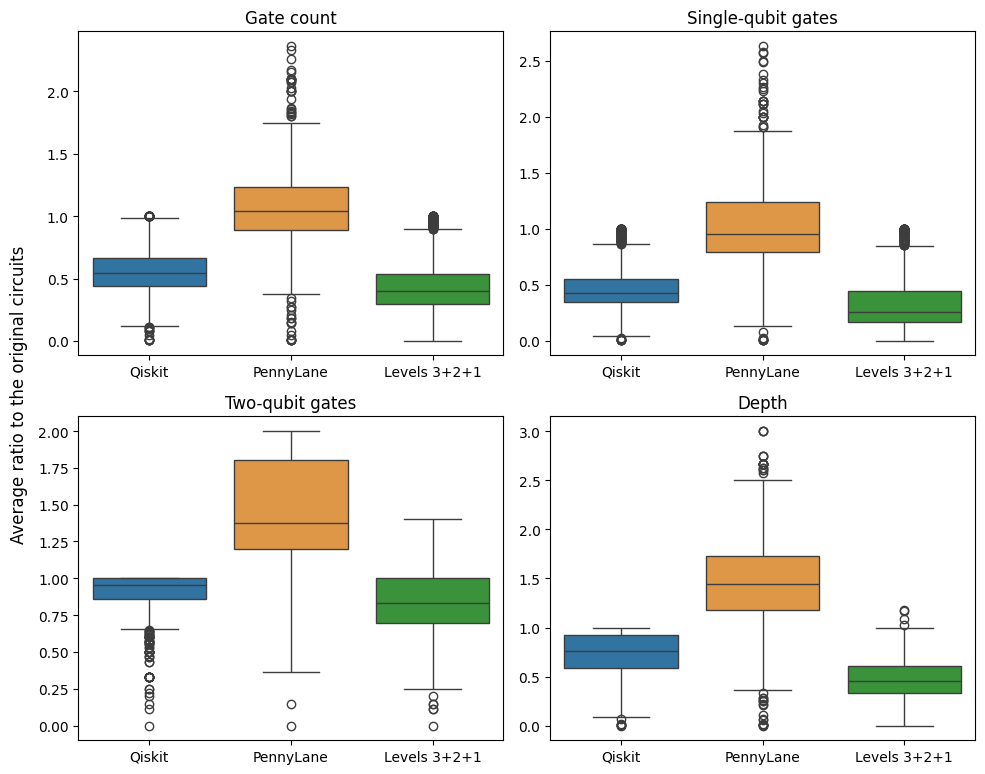

In [36]:
# fig 1
fig, axes = plt.subplots(2,2, figsize=(10, 8))
for i, metric in enumerate(['gates', '1q gates', '2q gates','depth']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': "#f7992e", 'Levels 3+2+1': '#2ca02c'}) # 'Qiskit\n(pattern matching)':'#7b1fb4', 'PennyLane': '#ff7f0e'
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    elif i==3:
        ax.set_title('Depth')
    ax.set_xlabel('')
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [37]:
mean_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean','std']).reset_index()
mean_df['mean_percent'] = (1-mean_df['mean'])*100
mean_df

,method,metric,mean,std,mean_percent
0,Levels 3+2+1,1q gates,0.343038,0.242021,65.696200
1,Levels 3+2+1,2q gates,0.813026,0.175510,18.697433
2,Levels 3+2+1,depth,0.482914,0.209088,51.708600
3,Levels 3+2+1,gate types,1.263670,0.290204,-26.367000
4,Levels 3+2+1,gates,0.447702,0.211567,55.229800
5,PennyLane,1q gates,1.031283,0.382217,-3.128300
6,PennyLane,2q gates,1.451505,0.385202,-45.150481
7,PennyLane,depth,1.465409,0.466442,-46.540900
8,PennyLane,gate types,1.021707,0.239938,-2.170700
9,PennyLane,gates,1.076616,0.320237,-7.661600
